# *stock_market_predictor_using_LSTM*

In [ ]:
# Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model

import yfinance as yf



In [ ]:
import yfinance as yf

# Function to get stock data
def get_stock_data(stock_symbol, start_date='2000-01-01', end_date='2024-12-31'):
    # Download stock data using yfinance
    df = yf.download(stock_symbol, start=start_date, end=end_date)

    # Optionally, you can handle missing values by using the `na_values` parameter
    df.fillna(method='ffill', inplace=True)  # Forward fill missing values
    return df

# Example usage:
stock_symbol = input("Enter stock symbol (e.g., MSFT for Microsoft): ")
df = get_stock_data(stock_symbol)

# Display the first few rows of the dataset
print(df.head())


Enter stock symbol (e.g., MSFT for Microsoft): MSFT


[*********************100%***********************]  1 of 1 completed

Price       Adj Close     Close     High       Low      Open    Volume
Ticker           MSFT      MSFT     MSFT      MSFT      MSFT      MSFT
Date                                                                  
2000-01-03  35.864075  58.28125  59.3125  56.00000  58.68750  53228400
2000-01-04  34.652584  56.31250  58.5625  56.12500  56.78125  54119000
2000-01-05  35.017941  56.90625  58.1875  54.68750  55.56250  64059600
2000-01-06  33.844921  55.00000  56.9375  54.18750  56.09375  54976600
2000-01-07  34.287224  55.71875  56.1250  53.65625  54.31250  62013600



<ipython-input-70-0c752cd9aeda>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:
# Check the structure of the dataset
print("Dataset Shape:", df.shape)
print("Dataset Structure (Head):\n", df.head())

Dataset Shape: (6280, 6)
Dataset Structure (Head):
 Price       Adj Close     Close     High       Low      Open    Volume
Ticker           MSFT      MSFT     MSFT      MSFT      MSFT      MSFT
Date                                                                  
2000-01-03  35.864075  58.28125  59.3125  56.00000  58.68750  53228400
2000-01-04  34.652584  56.31250  58.5625  56.12500  56.78125  54119000
2000-01-05  35.017941  56.90625  58.1875  54.68750  55.56250  64059600
2000-01-06  33.844921  55.00000  56.9375  54.18750  56.09375  54976600
2000-01-07  34.287224  55.71875  56.1250  53.65625  54.31250  62013600


In [ ]:
# Check for null values
print("\nNull Values in Each Column:\n", df.isnull().sum())



Null Values in Each Column:
 Price      Ticker
Adj Close  MSFT      0
Close      MSFT      0
High       MSFT      0
Low        MSFT      0
Open       MSFT      0
Volume     MSFT      0
dtype: int64


In [ ]:
# Handle missing values (if any)
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values by filling forward:")
    df.fillna(method='ffill', inplace=True)  # Forward fill missing values
    print("\nDataset after handling missing values:")
    print(df.head())
else:
    print("\nNo missing values in the dataset.")


No missing values in the dataset.


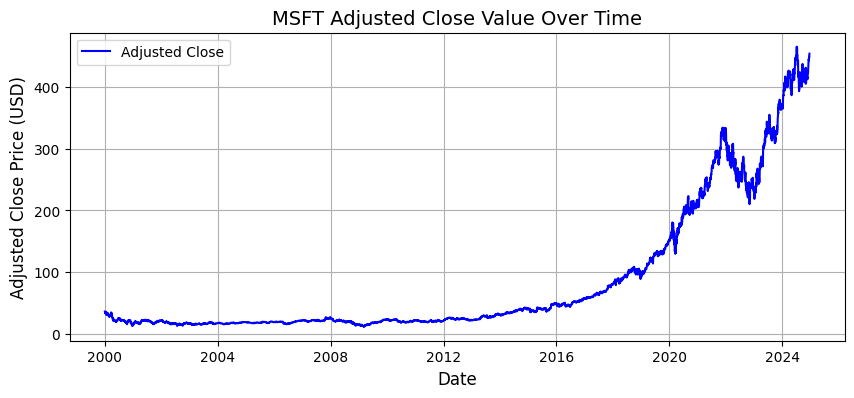

In [ ]:
# Plotting the Adjusted Close value
plt.figure(figsize=(10, 4))  # Set figure size
plt.plot(df['Adj Close'], label='Adjusted Close', color='blue')
plt.title(f"{stock_symbol} Adjusted Close Value Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Adjusted Close Price (USD)", fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])

# Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [ ]:
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2000-01-03,0.096254,0.096509,0.091483,0.078480
2000-01-04,0.092035,0.094852,0.091761,0.080006
2000-01-05,0.089337,0.094024,0.088564,0.097038
2000-01-06,0.090513,0.091263,0.087452,0.081475
2000-01-07,0.086570,0.089468,0.086270,0.093532


In [ ]:
# Splitting to Training set and Test set
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train = feature_transform.iloc[train_index]
    X_test = feature_transform.iloc[test_index]
    y_train = output_var.iloc[train_index].values.ravel()
    y_test = output_var.iloc[test_index].values.ravel()


In [ ]:
# Process the data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
# Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


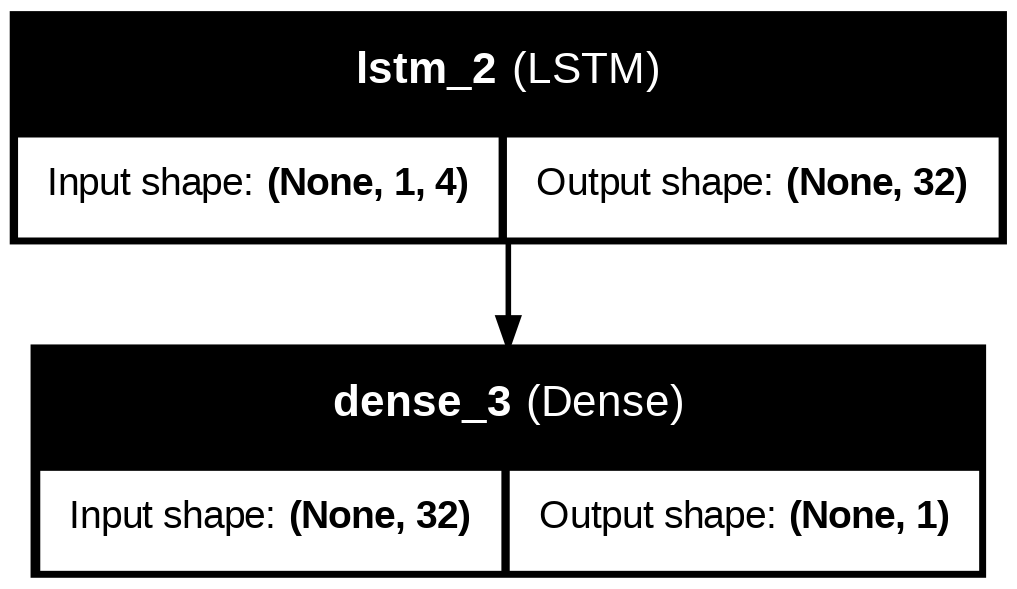

In [ ]:
# Visualize the model
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [ ]:
history=lstm.fit(X_train, y_train, epochs=10, batch_size=8, verbose=1, shuffle=False)

Epoch 1/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 731.4579
Epoch 2/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 287.6000
Epoch 3/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 516.4772
Epoch 4/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 590.2295
Epoch 5/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 451.3445
Epoch 6/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 249.3634
Epoch 7/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 120.8444
Epoch 8/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 50.8682
Epoch 9/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 20.1115
Epoch 10/10
714/714 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.9678


In [ ]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


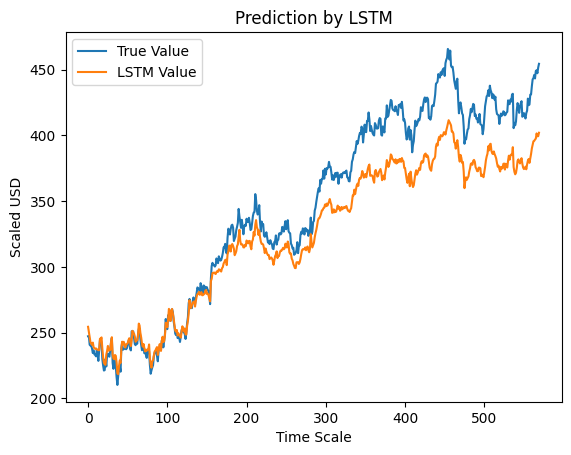

In [ ]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

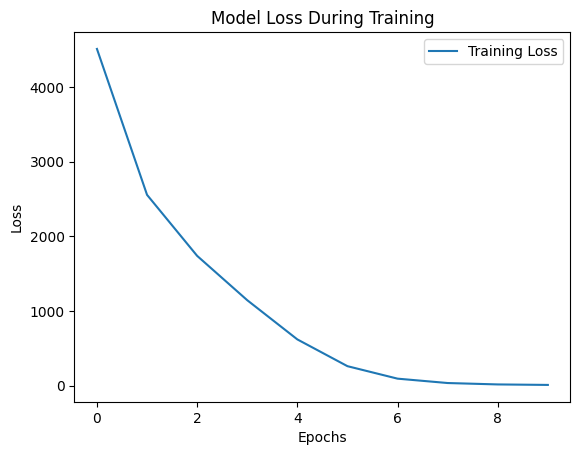

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


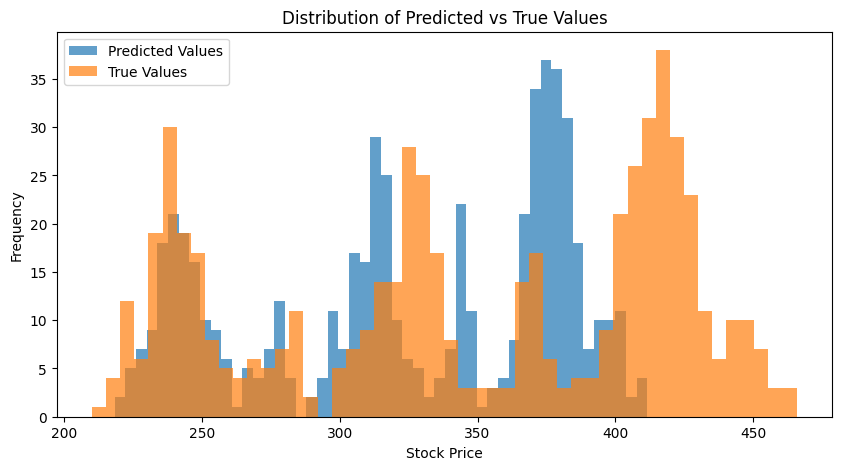

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(y_pred.flatten(), bins=50, alpha=0.7, label='Predicted Values')
plt.hist(y_test, bins=50, alpha=0.7, label='True Values')
plt.title('Distribution of Predicted vs True Values')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


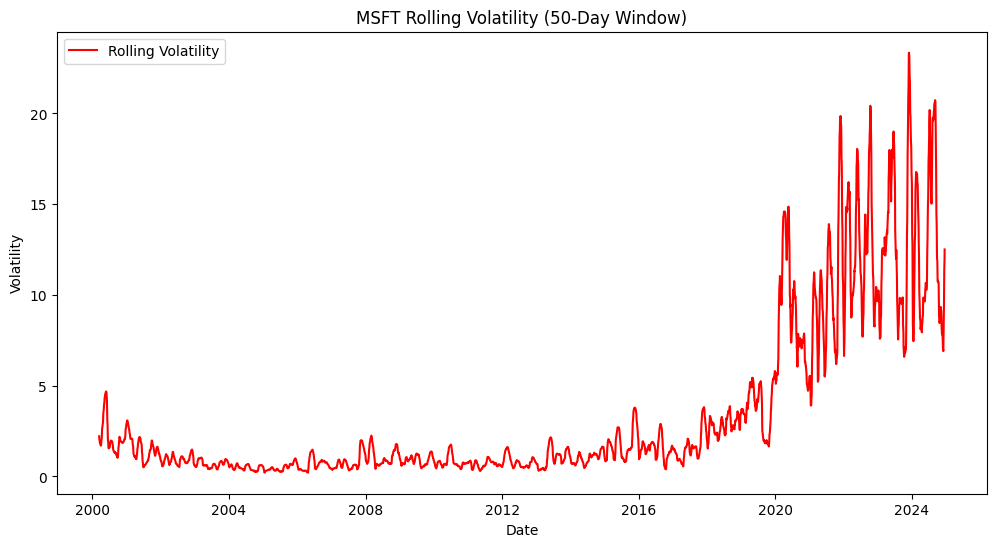

In [ ]:
df['Rolling Volatility'] = df['Adj Close'].rolling(window=50).std()
plt.figure(figsize=(12, 6))
plt.plot(df['Rolling Volatility'], label='Rolling Volatility', color='red')
plt.title(f'{stock_symbol} Rolling Volatility (50-Day Window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


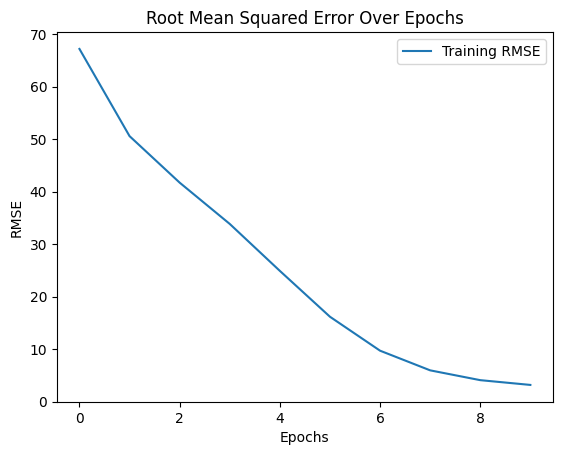

In [ ]:
from math import sqrt
train_mse = history.history['loss']
val_mse = history.history.get('val_loss', [])
train_rmse = [sqrt(x) for x in train_mse]
val_rmse = [sqrt(x) for x in val_mse]

plt.plot(train_rmse, label='Training RMSE')
if val_rmse:
    plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate model predictions for training and testing data
train_pred = lstm.predict(X_train)
test_pred = lstm.predict(X_test)

# Convert predictions and true values to 1D arrays
y_train = np.ravel(y_train)  # True training values
y_test = np.ravel(y_test)    # True testing values
train_pred = np.ravel(train_pred)  # Predicted training values
test_pred = np.ravel(test_pred)    # Predicted testing values

# Calculate metrics for Training Data
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

# Calculate metrics for Testing Data
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

# Print Training Metrics
print("\nTraining Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R-Squared (R²): {train_r2:.4f}")

# Print Testing Metrics
print("\nTesting Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R-Squared (R²): {test_r2:.4f}")



179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Training Set Evaluation Metrics:
Mean Squared Error (MSE): 19.9821
Root Mean Squared Error (RMSE): 4.4701
Mean Absolute Error (MAE): 3.7287
R-Squared (R²): 0.9963

Testing Set Evaluation Metrics:
Mean Squared Error (MSE): 778.1756
Root Mean Squared Error (RMSE): 27.8958
Mean Absolute Error (MAE): 22.5170
R-Squared (R²): 0.8533


In [ ]:
# Save the trained model as .h5
lstm.save("lstm_model.h5")
print("Model saved as lstm_model.h5")


Model saved as lstm_model.h5


# Stock_Market_Predictor_Using_RNN

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
import yfinance as yf

In [ ]:
# Function to Get Stock Data
def get_stock_data(stock_symbol, start_date='2000-01-01', end_date='2024-12-31'):
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    df.fillna(method='ffill', inplace=True)  # Forward fill missing values
    print("\nAvailable columns in the dataset:", df.columns)
    return df

In [ ]:
# Fetch Data
stock_symbol = input("Enter stock symbol (e.g., AAPL for Apple): ")
df = get_stock_data(stock_symbol)

# Check if 'Adj Close' is in columns
if 'Adj Close' not in df.columns:
    raise ValueError("'Adj Close' column not found. Please check the data for availability.")


Enter stock symbol (e.g., AAPL for Apple): MSFT


[*********************100%***********************]  1 of 1 completed


Available columns in the dataset: MultiIndex([('Adj Close', 'MSFT'),
            (    'Close', 'MSFT'),
            (     'High', 'MSFT'),
            (      'Low', 'MSFT'),
            (     'Open', 'MSFT'),
            (   'Volume', 'MSFT')],
           names=['Price', 'Ticker'])



<ipython-input-91-dcf1a01fe6a9>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [ ]:
# Select Target and Features
target = 'Adj Close'
features = ['Open', 'High', 'Low', 'Volume', target]  # Ensure 'Adj Close' is part of features

# Scale Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [ ]:
# Prepare Data for RNN
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, :-1])  # Features for the past 'time_step' days
        y.append(data[i+time_step, -1])  # Target value
    return np.array(X), np.array(y)


In [ ]:
# Define Time Step
time_step = 10
X, y = create_dataset(scaled_data, time_step)

In [ ]:
# Split Data into Training and Testing Sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")

Training Samples: 5016, Testing Samples: 1254


In [ ]:
# Build RNN Model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output Layer
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse Transform Predictions
train_predictions_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(train_predictions), len(features)-1)), train_predictions], axis=1))[:, -1]
y_train_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_train), len(features)-1)), y_train.reshape(-1, 1)], axis=1))[:, -1]

test_predictions_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(test_predictions), len(features)-1)), test_predictions], axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features)-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1244e-04 - val_loss: 0.0015
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.4844e-04 - val_loss: 0.0011
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4652e-04 - val_loss: 0.0012
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2820e-04 - val_loss: 0.0013
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0719e-04 - val_loss: 0.0021
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1766e-04 - val_loss: 0.0034
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7071e-05 - val_loss: 0.0014
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1035e-04 - val_loss: 5.3605e-04
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.8993e-05 - val_loss: 0.0022
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


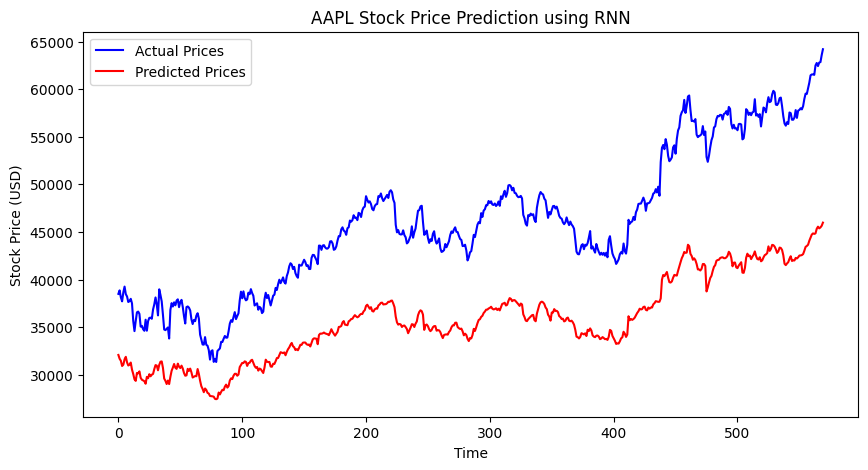

In [ ]:
# Plot Predicted vs Actual Values
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(test_predictions_inv, label='Predicted Prices', color='red')
plt.title(f"{stock_symbol} Stock Price Prediction using RNN")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()


In [ ]:
# Evaluation Metrics

# Print Evaluation Metrics
print("\nTraining Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R2 Score: {train_r2:.4f}")

print("\nTesting Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R2 Score: {test_r2:.4f}")


Training Set Evaluation Metrics:
Mean Squared Error (MSE): 4.5566
Root Mean Squared Error (RMSE): 2.1346
Mean Absolute Error (MAE): 1.7735
R2 Score: 0.9973

Testing Set Evaluation Metrics:
Mean Squared Error (MSE): 35.7638
Root Mean Squared Error (RMSE): 5.9803
Mean Absolute Error (MAE): 4.5940
R2 Score: 0.9593


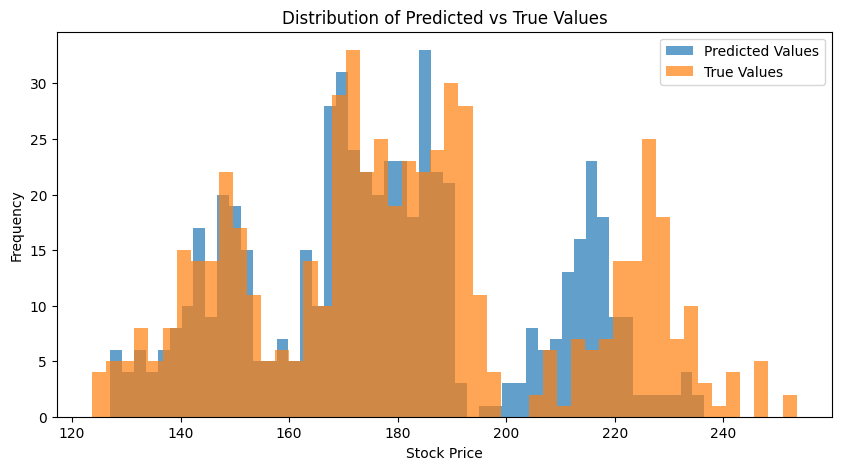

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(y_pred.flatten(), bins=50, alpha=0.7, label='Predicted Values')
plt.hist(y_test, bins=50, alpha=0.7, label='True Values')
plt.title('Distribution of Predicted vs True Values')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

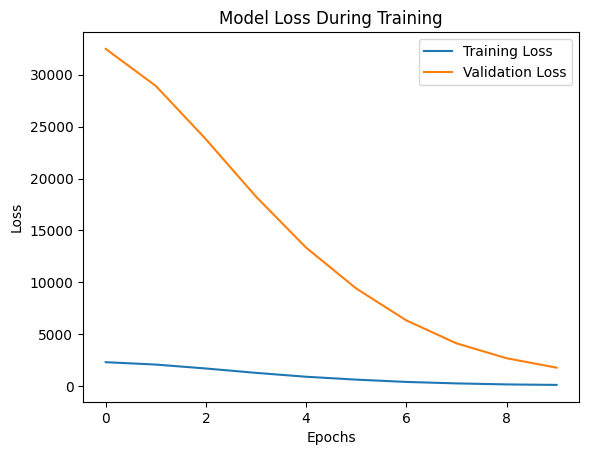

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

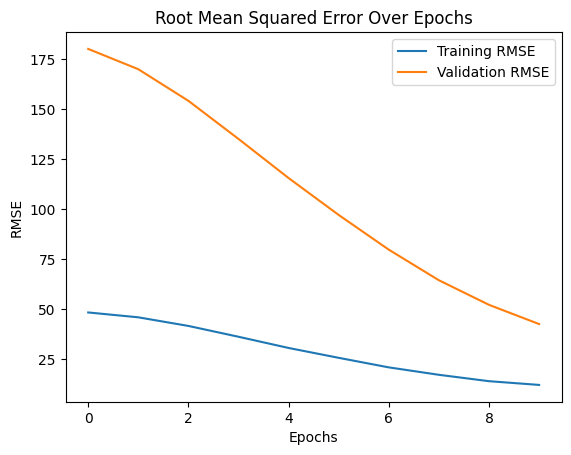

In [ ]:
from math import sqrt
train_mse = history.history['loss']
val_mse = history.history.get('val_loss', [])
train_rmse = [sqrt(x) for x in train_mse]
val_rmse = [sqrt(x) for x in val_mse]

plt.plot(train_rmse, label='Training RMSE')
if val_rmse:
    plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()


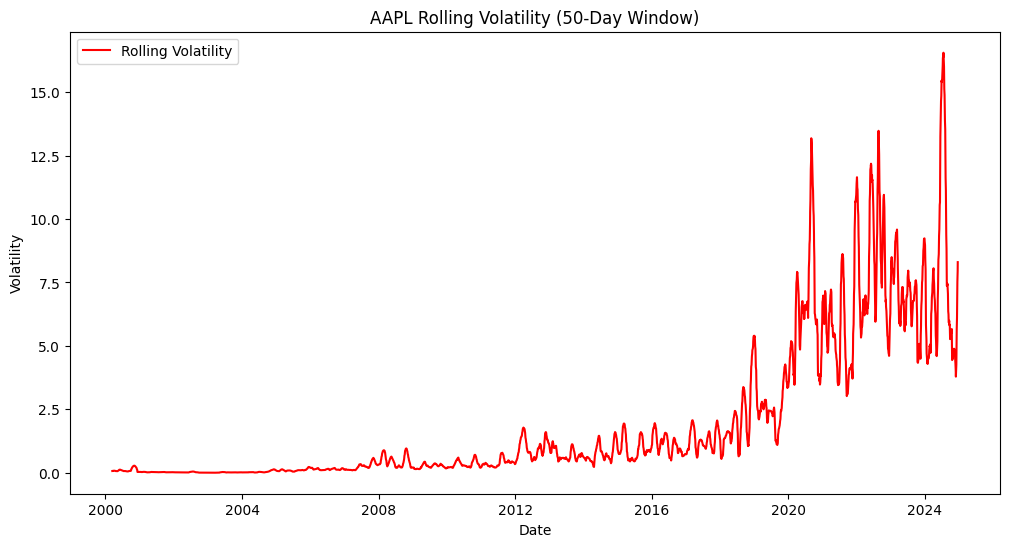

In [ ]:
df['Rolling Volatility'] = df['Adj Close'].rolling(window=50).std()
plt.figure(figsize=(12, 6))
plt.plot(df['Rolling Volatility'], label='Rolling Volatility', color='red')
plt.title(f'{stock_symbol} Rolling Volatility (50-Day Window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# **Stock_Market_Predictior_Using_LinearRegression**

Enter stock symbol (e.g., AAPL for Apple): AAPL


[*********************100%***********************]  1 of 1 completed
<ipython-input-67-690c41e5005d>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values



Available Columns: MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])


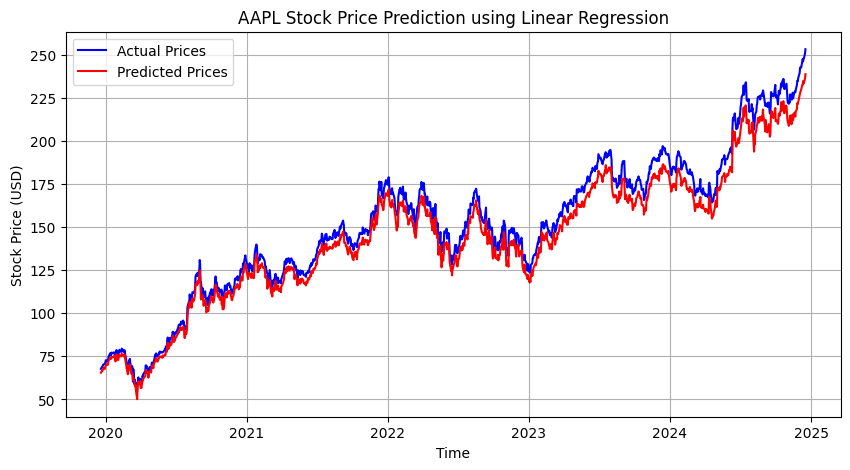


Training Set Evaluation Metrics:
Mean Squared Error (MSE): 0.4989
Root Mean Squared Error (RMSE): 0.7063
Mean Absolute Error (MAE): 0.5684
R2 Score: 0.9978

Testing Set Evaluation Metrics:
Mean Squared Error (MSE): 59.2325
Root Mean Squared Error (RMSE): 7.6963
Mean Absolute Error (MAE): 7.0757
R2 Score: 0.9659


In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to Get Stock Data
def get_stock_data(stock_symbol, start_date='2000-01-01', end_date='2024-12-31'):
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    df.fillna(method='ffill', inplace=True)  # Forward fill missing values
    return df

# Fetch Stock Data
stock_symbol = input("Enter stock symbol (e.g., AAPL for Apple): ")
df = get_stock_data(stock_symbol)

# Check Available Columns
print("\nAvailable Columns:", df.columns)

# Select Features and Target
if 'Adj Close' not in df.columns:
    raise ValueError("'Adj Close' column not found. Please check the stock data.")

target = 'Adj Close'
features = ['Open', 'High', 'Low', 'Volume']

# Prepare the Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
X = scaled_features
y = df[target].values

# Split into Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices', color='blue')
plt.plot(df.index[-len(test_predictions):], test_predictions, label='Predicted Prices', color='red')
plt.title(f"{stock_symbol} Stock Price Prediction using Linear Regression")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Metrics
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print Evaluation Metrics
print("\nTraining Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R2 Score: {train_r2:.4f}")

print("\nTesting Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R2 Score: {test_r2:.4f}")


# **Stock_Market_Prediction_Using_KNN**

Enter stock symbol (e.g., AAPL for Apple): AAPL


[*********************100%***********************]  1 of 1 completed
<ipython-input-68-0083f3bb93e2>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values



Available Columns: MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])


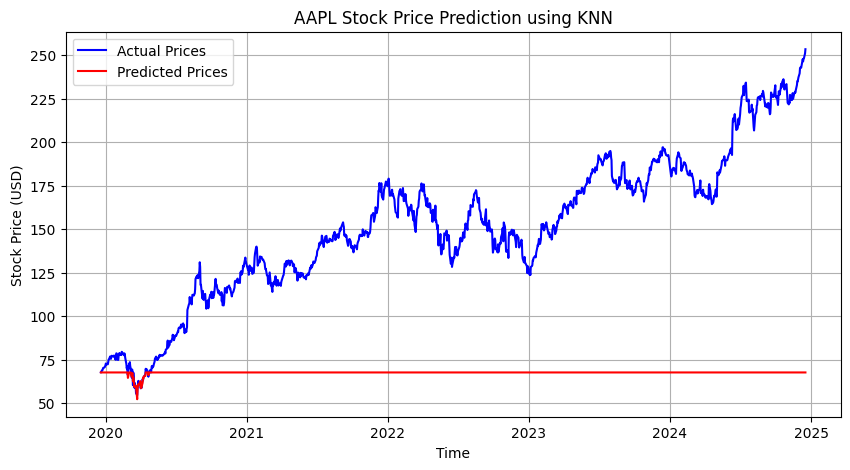


Training Set Evaluation Metrics:
Mean Squared Error (MSE): 0.0602
Root Mean Squared Error (RMSE): 0.2453
Mean Absolute Error (MAE): 0.1418
R2 Score: 0.9997

Testing Set Evaluation Metrics:
Mean Squared Error (MSE): 8714.5300
Root Mean Squared Error (RMSE): 93.3516
Mean Absolute Error (MAE): 83.6802
R2 Score: -4.0127


In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Function to Get Stock Data
def get_stock_data(stock_symbol, start_date='2000-01-01', end_date='2024-12-31'):
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    df.fillna(method='ffill', inplace=True)  # Forward fill missing values
    return df

# Fetch Stock Data
stock_symbol = input("Enter stock symbol (e.g., AAPL for Apple): ")
df = get_stock_data(stock_symbol)

# Check Available Columns
print("\nAvailable Columns:", df.columns)

# Select Features and Target
if 'Adj Close' not in df.columns:
    raise ValueError("'Adj Close' column not found. Please check the stock data.")

target = 'Adj Close'
features = ['Open', 'High', 'Low', 'Volume']

# Prepare the Data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
X = scaled_features
y = df[target].values

# Split into Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Train KNN Regressor Model
k = 5  # Number of neighbors
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train, y_train)

# Make Predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Prices', color='blue')
plt.plot(df.index[-len(test_predictions):], test_predictions, label='Predicted Prices', color='red')
plt.title(f"{stock_symbol} Stock Price Prediction using KNN")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Metrics
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Print Evaluation Metrics
print("\nTraining Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R2 Score: {train_r2:.4f}")

print("\nTesting Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R2 Score: {test_r2:.4f}")
